# Interpretability of Support Vector Machines 
#### Chrystalla Havadjia

In [1]:
#libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sklearn
import seaborn as sns

In [2]:
df = pd.read_csv(r'./heart.csv')
df.head(5)

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   3       145   233    1        0      150      0      2.3      0   
1   37    1   2       130   250    0        1      187      0      3.5      0   
2   41    0   1       130   204    0        0      172      0      1.4      2   
3   56    1   1       120   236    0        1      178      0      0.8      2   
4   57    0   0       120   354    0        1      163      1      0.6      2   

   ca  thal  target  
0   0     1       1  
1   0     2       1  
2   0     2       1  
3   0     2       1  
4   0     2       1

____________
## Data Exploration
- No missing data (thank you to the individuals who preprocessed this)
- All data is in numerical form for easy processing
- SVM work best with small datasets

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [4]:
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

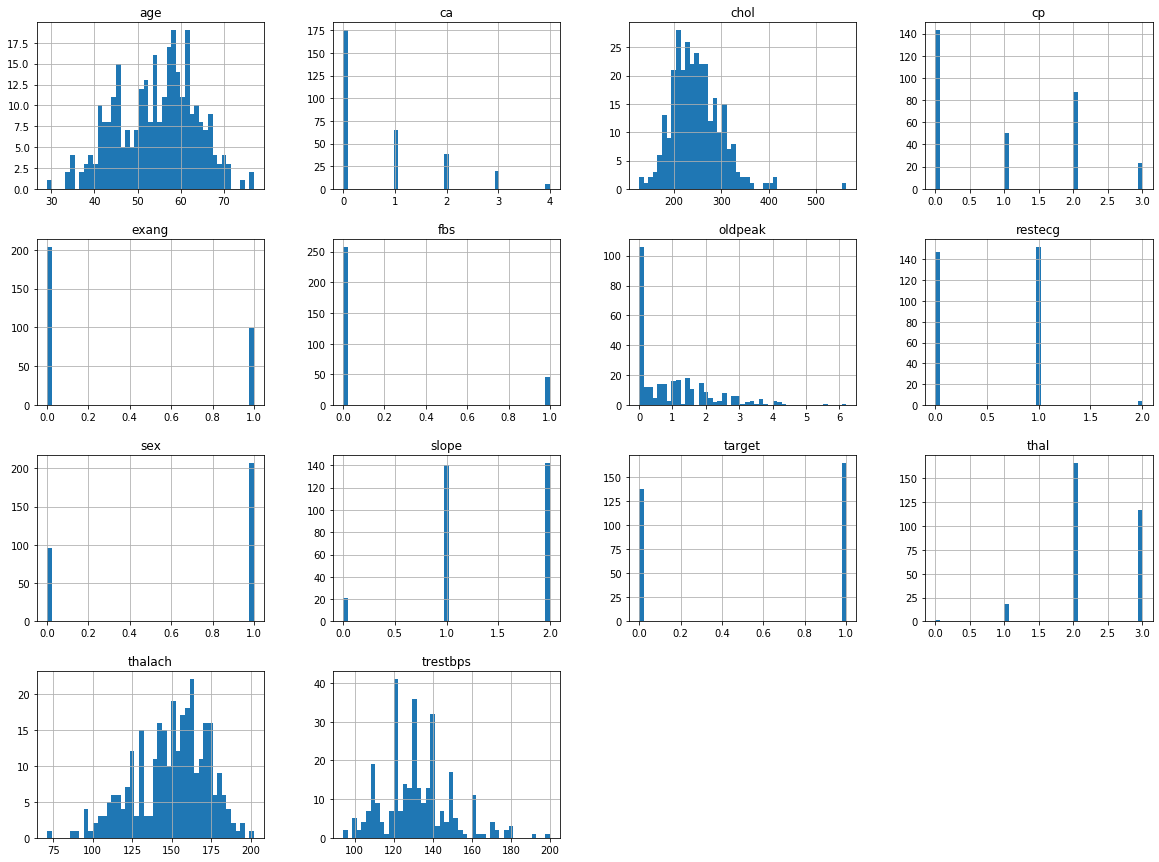

In [5]:
%matplotlib inline 

df.hist(bins=45, figsize=(20,15))
plt.show()

### Correlations 
- Target varible has a small corrrelation with fbs(fasting blood sugar > 120 mg/dl) and chol( serum cholestoral in mg/dl). 
- These colomns can be deleted from the analysis

In [6]:
### Investigate correlations between each variable and target variable
corr_matrix = df.corr()
corr_matrix['target'].sort_values(ascending = False)

target      1.000000
cp          0.433798
thalach     0.421741
slope       0.345877
restecg     0.137230
fbs        -0.028046
chol       -0.085239
trestbps   -0.144931
age        -0.225439
sex        -0.280937
thal       -0.344029
ca         -0.391724
oldpeak    -0.430696
exang      -0.436757
Name: target, dtype: float64

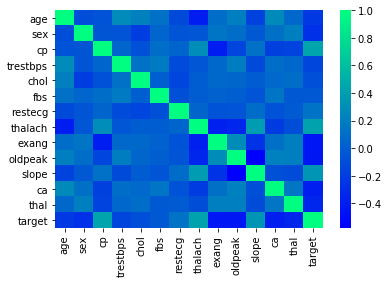

In [7]:
sns.heatmap(corr_matrix,cmap="winter")

______
## Data Preprocessing

In [8]:
#for dataset voice
# ###############
# df['label']=df['label'].replace(to_replace= 'male', value = 0)
# df['label']=df['label'].replace(to_replace= 'female', value = 1)
##############

In [9]:
def drop_uncorr_feat(corr_matrix,df,dep_colum,r): 

    """ Takes correlation Matrix as input
        
         Returns uncorrelated featurs
    """
    
    #drop uncorrelated columns 
    col_names_corr = corr_matrix[dep_colum].index

    i=0
    drop_col = []

    #deremine columns to be droped
    for row in corr_matrix[dep_colum]:
        if  (-r < row < r):
            drop_col.append(col_names_corr[i])
        i+=1

    return drop_col
    
    
drop_col = drop_uncorr_feat(corr_matrix,df,'target',0.2)

for i in range(len(drop_col)):
     del df[drop_col[i]]

### Standardize Data
- Distribution of values so that the mean of values is 0 and standard deveation is 1
- to determine point x use  y = (x-mean)/ standard deviation

In [10]:
#Define X and y variables
X = df.drop('target', axis =1)
y = df['target'].copy()

In [11]:
from sklearn.preprocessing import StandardScaler

# define standard scaler
scaler = StandardScaler(with_mean=False)
# transform data
X_scaled = scaler.fit_transform(X)

### Split, train and procude preditions

In [12]:
#Split dataset into train and test using 
from sklearn.model_selection import train_test_split

random_state = 2
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state= random_state, shuffle=True)

### PCA dimentionality reductions
- Determine features with main variance

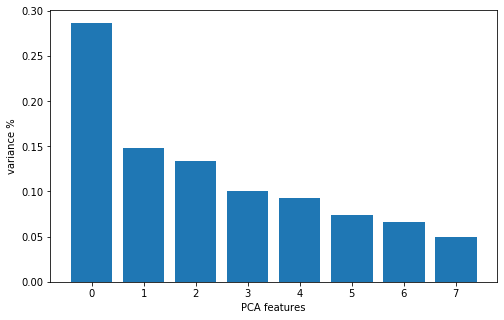

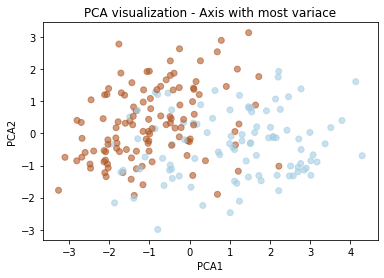

In [13]:
from sklearn.decomposition import PCA
%matplotlib inline

num_feat = df.columns.size-2

#create PCA instance
pca = PCA(n_components=num_feat)
X_train = pca.fit_transform(X_train)
X_test = pca.fit_transform(X_test)


# Save components to a DataFrame
# PCA_components = pd.DataFrame(X_train)

features = range(pca.n_components_)
    
#vari = sum(pca.explained_variance_ratio_)
#print(vari)

plt.figure(figsize=(8,5))
plt.bar(features, pca.explained_variance_ratio_)
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.show()

#visualize PCA before predictions
plt.scatter(X_train[:,0], X_train[:,1],alpha = 0.6, c=y_train, cmap=plt.cm.Paired)

plt.title("PCA visualization - Axis with most variace")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.show()

____
## Analysis

In [14]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

def get_cross_val(model, X, y):
    """
      cross validation: split data into kfolds to validate model
    
      Outputs: computes accuracy for each fold 
    """
    
    kf = KFold(shuffle=True, n_splits=3, random_state= random_state)
    
    acc = cross_val_score(model, X, y, 
                             scoring="accuracy", cv=kf)
    acc = acc.mean()
    print('Cross Validation Mean Accuracy: {0:.2f}'.format(acc * 100.0))

In [15]:
def get_visualiz(X_train,y_train,clf,support_vectors): 
    # get the separating hyperplane
    w = clf.coef_[0]
    a = - w[0] / w[1]
    xx = np.linspace(-3, 3)
    yy = a * xx - (clf.intercept_[0]) / w[1]

    # plot the parallels to the separating hyperplane that pass through the
    margin = 1 / np.sqrt(np.sum(clf.coef_ ** 2))
    yy_down = yy - np.sqrt(1 + a ** 2) * margin
    yy_up = yy + np.sqrt(1 + a ** 2) * margin


    # plot the line, the points, and the nearest vectors to the plane
    plt.figure(figsize=(13, 8))
    plt.clf()
    plt.plot(xx, yy, 'k-')
    plt.plot(xx, yy_down, 'k--')
    plt.plot(xx, yy_up, 'k--')

    if support_vectors == True:
        plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=60,
                    facecolors='none', zorder=30, edgecolors='r')
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, zorder=30, cmap=plt.cm.Paired, edgecolors='k')



    X1, X2 = np.meshgrid(np.arange(start = X_train[:, 0].min() - 2, stop = X_train[:, 0].max() + 2, step = 0.01),
                         np.arange(start = X_train[:, 1].min() - 2, stop = X_train[:, 1].max() + 2, step = 0.01))

    Xpred = np.array([X1.ravel(), X2.ravel()] + [np.repeat(0, X1.ravel().size) for _ in range(num_feat-2)]).T
    pred = clf.decision_function(Xpred).reshape(X1.shape)    
    plt.contourf(X1, X2, pred, alpha=1.0, cmap="PuOr", levels=np.linspace(pred.min(), pred.max(), 100))
    
    plt.scatter(X_train[:, 0], X_train[:, 1],alpha = 0.7, c=y_train, cmap=plt.cm.Paired)

    plt.ylim(-3.8,3.8)
    print("\n\n\t\t\t\t   Model - " , clf)
    plt.title("PCA visualization ")
    plt.xlabel("PCA1")
    plt.ylabel("PCA2")
    plt.show()

In [16]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

svclassifier = SVC(kernel='linear')
svclassifier.fit(X_train, y_train)

y_pred = svclassifier.predict(X_test)

    # Evaluate on test data
print("--- Evaluation ---\n", svclassifier)
get_cross_val(svclassifier,X_train, y_train)
accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)
print('Accuracy: {0:.2f}'.format(accuracy * 100.0))
print('Classification Report:')
print(classification_report(y_test, y_pred))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

--- Evaluation ---
 SVC(kernel='linear')
Cross Validation Mean Accuracy: 79.24
Accuracy: 78.02
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.78      0.76        41
           1       0.81      0.78      0.80        50

    accuracy                           0.78        91
   macro avg       0.78      0.78      0.78        91
weighted avg       0.78      0.78      0.78        91

Confusion Matrix:
[[32  9]
 [11 39]]




				   Model -  SVC(kernel='linear')


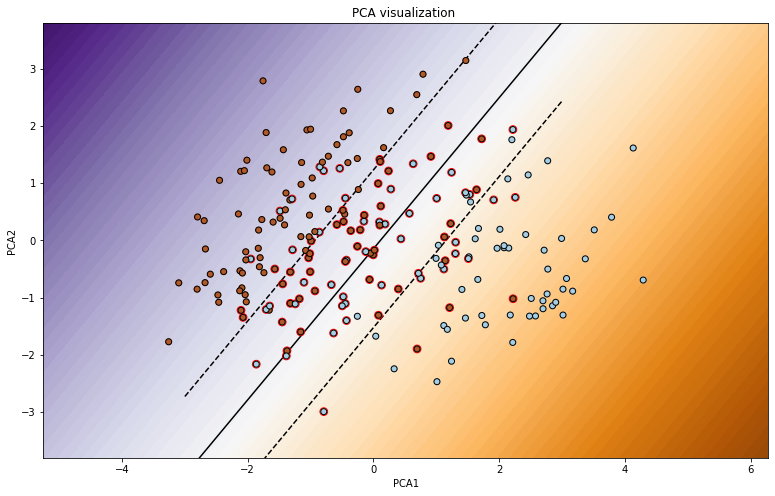

In [17]:
support_vectors = True
clf = svclassifier
get_visualiz(X_train,y_train,clf,support_vectors) 
print("\t\t\t\t\t  Tranng data")

					  Tranng data


				   Model -  SVC(kernel='linear')


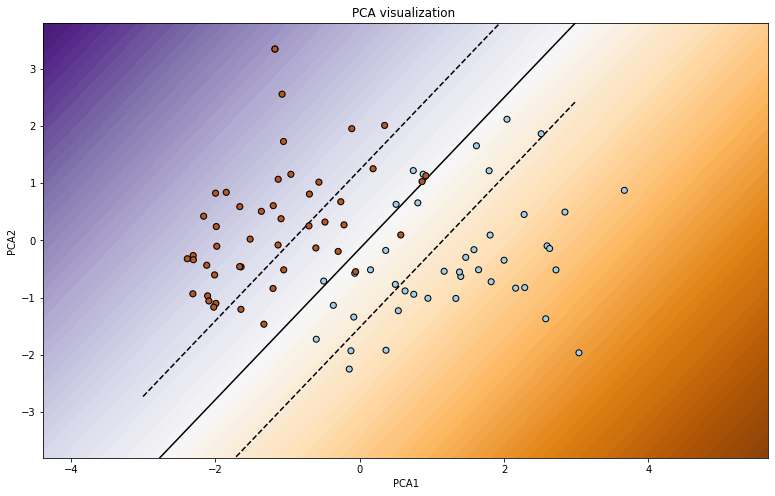

					  Testing data


In [18]:
support_vectors = False

get_visualiz(X_test,y_pred,svclassifier,support_vectors)
print("\t\t\t\t\t  Testing data")

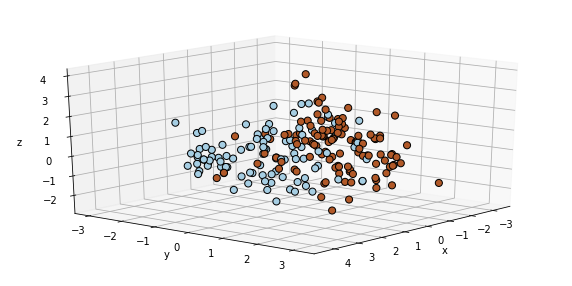

In [19]:
from mpl_toolkits import mplot3d #The library must be imported, otherwise the following projection="3d" will report an error
 
 #elev Up and down rotation angle
 #azim Parallel rotation angle
def plot_3D(elev = 20, azim = 40, X=X_train, y=y_train):
    fig = plt.subplots(figsize=(10,5))
    ax = plt.subplot(projection="3d")
    ax.scatter3D(X[:,0], X[:,1],X[:,2], c = y,s=50,alpha = 1, cmap=plt.cm.Paired,  edgecolors='k')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    plt.show()
    
plot_3D()

In [20]:
def plot_svc_decision_function(model, plot_support, ax=None):
    """Plot the decision function for a 2D SVC"""
 
    # create grid to evaluate model
    XX, YY = np.meshgrid(np.arange(start = X_train[:, 0].min() - 2, stop = X_train[:, 0].max() + 2, step = 0.01),
                          np.arange(start = X_train[:, 1].min() - 2, stop = X_train[:, 1].max() + 2, step = 0.01))

    xy = np.array([XX.ravel(), YY.ravel()] + [np.repeat(0, XX.ravel().size) for _ in range(num_feat-2)]).T
    P = model.decision_function(xy).reshape(XX.shape) 
    
    
    fig, ax = plt.subplots(figsize=(13,8))
    
    # plot decision boundary and margins
    ax.contour(XX, YY, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
    
    ax.contourf(XX, YY, P, alpha=1, cmap="PuOr", levels=np.linspace(P.min(), P.max(), 100))
    
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train,alpha = 1, cmap=plt.cm.Paired,  edgecolors='k')

    ax.set_title('PCA visualization')
    ax.set_xlabel('PCA1')
    ax.set_ylabel('PCA2')
    
    
    # plot support vectors
    if plot_support == True:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=60, facecolors='none', zorder=10, edgecolors='r');

--- Evaluation ---
 SVC() rbf kernal
Cross Validation Mean Accuracy: 80.19
Accuracy: 81.32
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.78      0.79        41
           1       0.82      0.84      0.83        50

    accuracy                           0.81        91
   macro avg       0.81      0.81      0.81        91
weighted avg       0.81      0.81      0.81        91

Confusion Matrix:
[[32  9]
 [ 8 42]]


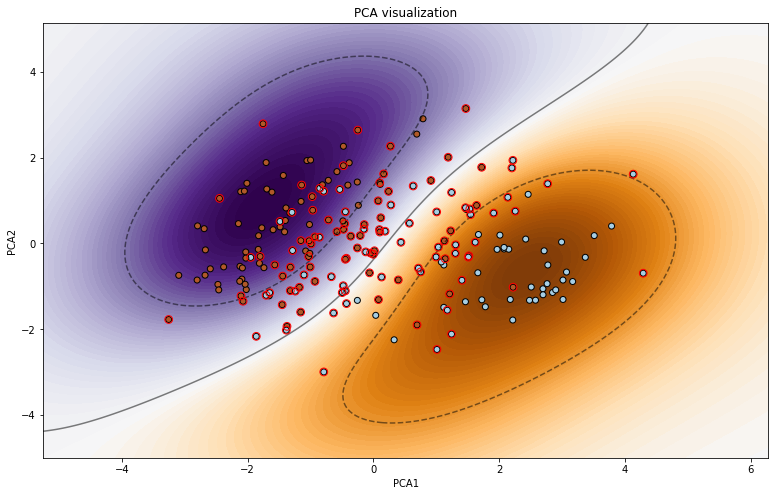

In [21]:
svclassifier_rbf = SVC(kernel='rbf')
svclassifier_rbf.fit(X_train, y_train)

y_pred = svclassifier_rbf.predict(X_test)

# Evaluate on test data
print("--- Evaluation ---\n", svclassifier_rbf, "rbf kernal")
get_cross_val(svclassifier_rbf,X_train, y_train)
accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)
print('Accuracy: {0:.2f}'.format(accuracy * 100.0))
print('Classification Report:')
print(classification_report(y_test, y_pred))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))


support_vectors = True
plot_svc_decision_function(svclassifier_rbf,support_vectors)

--- Evaluation ---
 SVC(kernel='sigmoid')
Cross Validation Mean Accuracy: 78.77
Accuracy: 78.02
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.78      0.76        41
           1       0.81      0.78      0.80        50

    accuracy                           0.78        91
   macro avg       0.78      0.78      0.78        91
weighted avg       0.78      0.78      0.78        91

Confusion Matrix:
[[32  9]
 [11 39]]


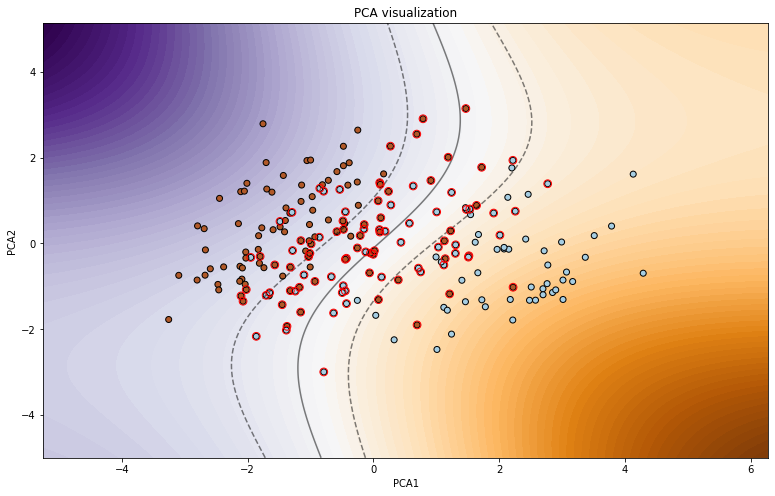

In [22]:
svclassifier = SVC(kernel='sigmoid')
svclassifier.fit(X_train, y_train)

y_pred = svclassifier.predict(X_test)

# Evaluate on test data
print("--- Evaluation ---\n", svclassifier)
get_cross_val(svclassifier,X_train, y_train)
accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)
print('Accuracy: {0:.2f}'.format(accuracy * 100.0))
print('Classification Report:')
print(classification_report(y_test, y_pred))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

clf = svclassifier

support_vectors = True
plot_svc_decision_function(clf, support_vectors)

_________________________
# Neural Networks
MLP classifer (using default parameters)
mpls are often used for clasification


---- Evaluation ----
 MLP
Cross Validation Mean Accuracy: 80.67
Accuracy: 79.12
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.80      0.78        41
           1       0.83      0.78      0.80        50

    accuracy                           0.79        91
   macro avg       0.79      0.79      0.79        91
weighted avg       0.79      0.79      0.79        91

Confusion Matrix:
[[33  8]
 [11 39]]


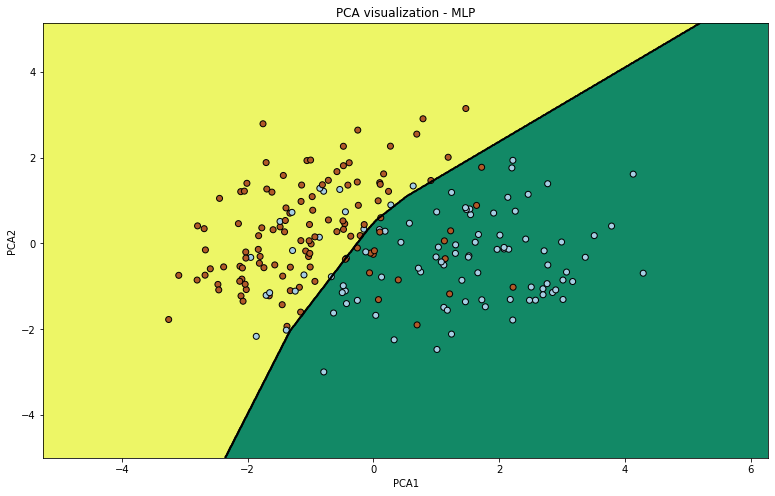

In [35]:
# Import libraries
import pandas
import joblib
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection
import sklearn.metrics
import sklearn.neural_network
# Train and evaluate

                                                                
# Create a model
model = sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(5,), activation='relu', solver='adam', 
                                             alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001, power_t=0.0, 
                                             max_iter=1500, shuffle=True, random_state= 2, tol=0.0002, verbose=False, warm_start=False, momentum=0.0, 
                                             early_stopping=False)

def train_and_evaluate(X_train, Y_train, X_test, Y_test,model):
    

    # Train the model on the whole data set
    model.fit(X_train, y_train)

    # Evaluate on test data
    print('\n---- Evaluation ----\n MLP')
    predictions = model.predict(X_test)
    get_cross_val(model,X_train, y_train)
    accuracy = sklearn.metrics.accuracy_score(y_test, predictions)
    print('Accuracy: {0:.2f}'.format(accuracy * 100.0))
    print('Classification Report:')
    print(sklearn.metrics.classification_report(y_test, predictions))
    print('Confusion Matrix:')
    print(sklearn.metrics.confusion_matrix(y_test, predictions))
    
# Plot the classifier
def plot_classifier(X, Y,model):

    # create grid to evaluate model
    xx, yy = np.meshgrid(np.arange(start = X_train[:, 0].min() - 2, stop = X_train[:, 0].max() + 2, step = 0.01),
                          np.arange(start = X_train[:, 1].min() - 2, stop = X_train[:, 1].max() + 2, step = 0.01))

    xy = np.array([xx.ravel(), yy.ravel()] + [np.repeat(0, xx.ravel().size) for _ in range(num_feat-2)]).T  
    
    # Make predictions
    Z = model.predict(xy)
    Z = Z.reshape(xx.shape)
    
    fig, ax = plt.subplots(figsize=(13,8))
    
    # plot decision boundary and margins
    ax.contour(xx, yy, Z, colors='k',alpha=0.5)
    
    ax.contourf(xx, yy, Z, alpha=1, cmap="summer")#, levels=np.linspace(Z.min(), Z.max(), 100))
    
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train,alpha = 1, cmap=plt.cm.Paired,  edgecolors='k')

    ax.set_title('PCA visualization - MLP')
    ax.set_xlabel('PCA1')
    ax.set_ylabel('PCA2')
    
#     ax.scatter(svclassifier_rbf.support_vectors_[:, 0],
#                    svclassifier_rbf.support_vectors_[:, 1],
#                    s=60, facecolors='none', zorder=10, edgecolors='r');

# Train and evaluate
train_and_evaluate(X_train, y_train, X_test, y_test,model)
# Plot classifier

plot_classifier(X_train, y,model)


In [36]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold

#Fine tune MLP
skf = StratifiedKFold(n_splits=3, random_state= random_state, shuffle=True) # Define the stratified ksplit


parameter_space = {
    'hidden_layer_sizes': [(5,),(10,)],
    'power_t': [0.0,0.5],
    'alpha': [0.0001],
    'momentum': [0.0,0.5],
    'tol' : [0.0002,0.0003]
}


estimator = model

scores = ['roc_auc','accuracy']

for score in scores:
    print()
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        estimator, parameter_space, scoring=score,#scoring='%s_macro' % score,
        cv=skf)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))



# Tuning hyper-parameters for roc_auc

Best parameters set found on development set:
{'alpha': 0.0001, 'hidden_layer_sizes': (5,), 'momentum': 0.0, 'power_t': 0.0, 'tol': 0.0002}

Grid scores on development set:

0.872 (+/-0.174) for {'alpha': 0.0001, 'hidden_layer_sizes': (5,), 'momentum': 0.0, 'power_t': 0.0, 'tol': 0.0002}
0.868 (+/-0.165) for {'alpha': 0.0001, 'hidden_layer_sizes': (5,), 'momentum': 0.0, 'power_t': 0.0, 'tol': 0.0003}
0.872 (+/-0.174) for {'alpha': 0.0001, 'hidden_layer_sizes': (5,), 'momentum': 0.0, 'power_t': 0.5, 'tol': 0.0002}
0.868 (+/-0.165) for {'alpha': 0.0001, 'hidden_layer_sizes': (5,), 'momentum': 0.0, 'power_t': 0.5, 'tol': 0.0003}
0.872 (+/-0.174) for {'alpha': 0.0001, 'hidden_layer_sizes': (5,), 'momentum': 0.0, 'power_t': 1.0, 'tol': 0.0002}
0.868 (+/-0.165) for {'alpha': 0.0001, 'hidden_layer_sizes': (5,), 'momentum': 0.0, 'power_t': 1.0, 'tol': 0.0003}
0.872 (+/-0.174) for {'alpha': 0.0001, 'hidden_layer_sizes': (5,), 'momentum': 0.5, 'power_t': 0

In [104]:
import lime
import lime.lime_tabular

feature_names = X.columns
  
predict_fn_MLP = lambda x: model.predict_proba(x).astype(float)


explainer = lime.lime_tabular.LimeTabularExplainer(np.array(X_train),  
                            mode='classification',training_labels=df['target'],feature_names=feature_names)


# asking for explanation for LIME model
exp = explainer.explain_instance(X_test[8,:], predict_fn_MLP, num_features=8)

exp.as_pyplot_figure() 
exp.show_in_notebook(show_all = False)


In [98]:
exp = explainer.explain_instance(X_test[30,:], predict_fn_MLP, num_features=8)

exp.as_pyplot_figure() 
exp.show_in_notebook(show_all = False)

references

https://www.kaggle.com/seanzhang1997/logistic-svc-rfc-neural-network-nn-is-the-best

https://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane.html

https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html

https://www.annytab.com/neural-network-classification-in-python/
